In [15]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation


In [16]:
becaons = np.array([[-2.5, -2.5], [2.5, -2.5], [-2.5, 2.5], [2.5, 2.5]])
becaons = np.array([[0, -2.5], [0, 2.5]])
becaons = np.array([[0, 0]])

x0 = np.array([2.5, 0])
sigma_transition = 0.01
sigma_measurement = 0.02
step_size = 1


In [17]:
def get_range_meas(x, beacons):
    return np.linalg.norm(beacons - x, axis=1)

def get_range_meas_with_noise(x, beacons, sigma = sigma_measurement):
    return get_range_meas(x, beacons) + np.random.normal(0, sigma, beacons.shape[0])

In [18]:
def transition_model(x, command):
    return x + command

def transition_model_with_noise(x, command, sigma = sigma_transition):
    return transition_model(x, command) + np.random.normal(0, sigma, x.shape[0])

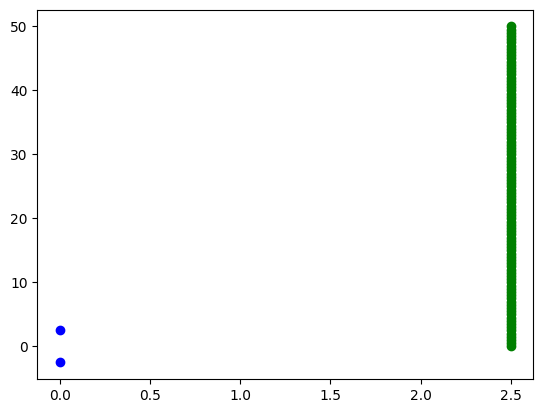

In [19]:
# genrate path and measurements
M = 100
path = [x0]
measurements = [get_range_meas_with_noise(x0, becaons)]
commands = np.random.normal(0, step_size, (M,2))
commands = [0.,0.5]
commands = np.tile(commands,(M,1))

for i in range(M):
    
    path.append(transition_model(path[-1], command=commands[i]))
    measurements.append(get_range_meas_with_noise(path[-1], becaons))
    
#plt the path and measurements
path = np.array(path)
measurements = np.array(measurements)
plt.plot(path[:, 0], path[:, 1], 'g')
plt.scatter(becaons[:, 0], becaons[:, 1], c='b')
plt.scatter(path[:, 0], path[:, 1], c='g')
plt.show()


In [20]:
def propgate_all_particle(particle, command):
    return np.array([transition_model_with_noise(particle[i], command) for i in range(particle.shape[0])])

def calc_weight(particle, meas, sigma_measurement):
    Sigma = np.diag([sigma_measurement]*meas.shape[0])
    Sigma_inv = np.linalg.inv(Sigma)
    v = np.abs((get_range_meas(particle, becaons) - meas).reshape(1,-1))
    Mnorm = v@Sigma_inv@v.T
    return np.exp(-0.5*Mnorm).item()

def calc_all_weight(particles, meas,sigma_measurement):
    return np.array([calc_weight(particles[i], meas, sigma_measurement) for i in range(particles.shape[0])])

def normalize_weight(weight):
    return weight / np.sum(weight)

def calc_N_eff(weight):
    return 1 / np.sum(weight ** 2)

def resampling(particles, weight):
    n_eff = calc_N_eff(weight)
    print(n_eff)
    if n_eff < particles.shape[0]:
        return particles[np.random.choice(particles.shape[0], particles.shape[0], p=weight)]
    else:
        return particles

    
def run_particle_filter_step(particles, command, meas,sigma_measurement):
    weight = calc_all_weight(particles, meas, sigma_measurement)
    weight = normalize_weight(weight)
    particles = resampling(particles, weight)
    particles = propgate_all_particle(particles, command)
    return particles, weight

def run_particle_filter(m,commands,particles):
    for i in range(m):
        particles, weight = run_particle_filter_step(particles, commands[i-1], measurements[i])

1.7587421294858467
899.6172092183683
935.1221451718598
983.0471776777218
991.4499008185688
996.5827784768724
997.8462195229125
997.1551813318724
998.2531568887092
997.4918294275265
993.392243305449
996.3790430590083
983.9316234084708
984.3000024503709
990.7917925207314
994.2072580865073
992.7711385988047
987.1401285658687
992.3586387520346
980.666927072379
995.3928969137604
992.9403971021571
994.3348865079876
995.4358609199559
995.4115554849185
995.2885823689056
993.9417953506637
994.1844265835841
995.4191163010911
992.5639084924295
996.7108201057885
995.2269824732019
993.6079121814222
995.5683022724672
994.2842068506795
987.4823764247916
994.7588399485668
986.6836270172417
996.3019309252787
996.3388253431388
996.5006351127514
996.7583377605429
994.7562059508291
995.1969904456137
996.1978904218216
996.4141142633611
994.3691306586986
996.7687155085998
996.9827077426094
989.9903339151067
991.9768441832415
994.6482049984439
996.6112605520482
996.3943904659029
996.8738042901718
996.5001548

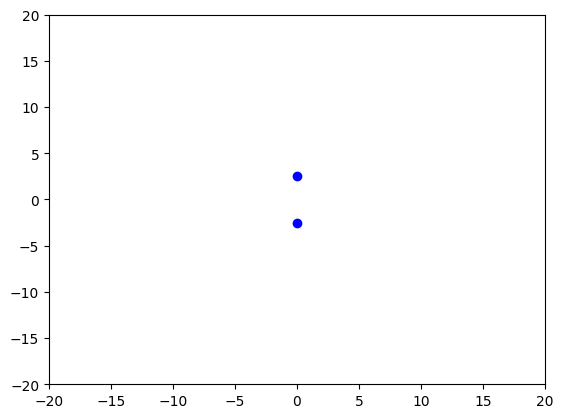

In [21]:
# sample unfomrly particles:
N = 1000
particles = np.random.uniform(-10, 10, (N, 2))
# particles = np.array([[5,0],[-5,0]])

#animation of particle filter and save as a gif:
fig, ax = plt.subplots()
sc_path, = ax.plot([], [], c='g',marker='o')
sc = ax.scatter([], [], color='red')
sc_beacons = ax.scatter(becaons[:, 0], becaons[:, 1], c='b')
def init():
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    sc_path.set_data([], [])
def animate(i):
    global particles
    sc_path.set_data(path[:i+1, 0],path[:i+1, 1])
    sc.set_offsets(particles)
    particles, weight = run_particle_filter_step(particles, commands[i], measurements[i],sigma_measurement)
    return sc, sc_path
ani = animation.FuncAnimation(fig, animate, frames=M, init_func=init, interval=500)
ani.save('particle_filter.gif', writer='imagemagick')
